# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',delimiter = ';')

# Load in the feature summary file.
feature_info = pd.read_csv('AZDIAS_Feature_Summary.csv',delimiter = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
feature_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [5]:
# Checking number of missing values
azdias.isnull().sum()[azdias.isnull().sum() > 0]

CJT_GESAMTTYP            4854
GFK_URLAUBERTYP          4854
LP_LEBENSPHASE_FEIN      4854
LP_LEBENSPHASE_GROB      4854
LP_FAMILIE_FEIN          4854
LP_FAMILIE_GROB          4854
LP_STATUS_FEIN           4854
LP_STATUS_GROB           4854
RETOURTYP_BK_S           4854
SOHO_KZ                 73499
TITEL_KZ                73499
ALTER_HH                73499
ANZ_PERSONEN            73499
ANZ_TITEL               73499
HH_EINKOMMEN_SCORE      18348
KK_KUNDENTYP           584612
W_KEIT_KIND_HH         107602
WOHNDAUER_2008          73499
ANZ_HAUSHALTE_AKTIV     93148
ANZ_HH_TITEL            97008
GEBAEUDETYP             93148
KONSUMNAEHE             73969
MIN_GEBAEUDEJAHR        93148
OST_WEST_KZ             93148
WOHNLAGE                93148
CAMEO_DEUG_2015         98979
CAMEO_DEU_2015          98979
CAMEO_INTL_2015         98979
KBA05_ANTG1            133324
KBA05_ANTG2            133324
KBA05_ANTG3            133324
KBA05_ANTG4            133324
KBA05_BAUMAX           133324
KBA05_GBZ 

In [6]:
feature_info['information_level'].value_counts()

person            43
macrocell_plz8     8
building           7
household          7
microcell_rr3      6
region_rr1         5
microcell_rr4      3
postcode           3
community          3
Name: information_level, dtype: int64

In [7]:
feature_info['type'].value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

In [8]:
# Exploring what mixed variables look like
print(feature_info[feature_info.loc[:,'type'] == 'mixed'].iloc[0,:])

print('\nValues for "LP_LEBENSPHASE_FEIN":')
azdias.loc[:,'LP_LEBENSPHASE_FEIN'].value_counts()

attribute             LP_LEBENSPHASE_FEIN
information_level                  person
type                                mixed
missing_or_unknown                    [0]
Name: 15, dtype: object

Values for "LP_LEBENSPHASE_FEIN":


0.0     92778
1.0     62667
5.0     55542
6.0     45614
2.0     39434
8.0     30475
11.0    26710
29.0    26577
7.0     26508
13.0    26085
10.0    25789
31.0    23987
12.0    23300
30.0    22361
15.0    20062
3.0     19985
19.0    19484
37.0    18525
4.0     17595
14.0    17529
20.0    17132
32.0    17105
39.0    16182
40.0    15150
27.0    14475
16.0    14466
38.0    13914
35.0    13679
34.0    13074
9.0     13066
21.0    12766
28.0    12264
24.0    12091
36.0    10505
25.0    10370
23.0     9191
22.0     7224
18.0     7168
33.0     6066
17.0     5888
26.0     3584
Name: LP_LEBENSPHASE_FEIN, dtype: int64

In [9]:
# Value type for the above
azdias.loc[:,'LP_LEBENSPHASE_FEIN'].values.dtype

dtype('float64')

In [10]:
# Checking out interval type feature
azdias.loc[:,feature_info[feature_info.type == 'interval'].attribute].head(10)

,ALTER_HH
0,NaN
1,0.0
2,17.0
3,13.0
4,20.0
5,10.0
6,0.0
7,14.0
8,16.0
9,17.0


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [11]:
# Creating lists to store all the columns that we drop and create during our preprocessing
dropped_cols = []

In [12]:
# Checking out what type of missing values do we have
feature_info.missing_or_unknown.value_counts()

[-1]        26
[-1,9]      17
[-1,0]      16
[0]         12
[]          10
[XX]         1
[-1,XX]      1
[-1,0,9]     1
[-1,X]       1
Name: missing_or_unknown, dtype: int64

In [13]:
# We can use Regex for parsing the missing values and turning them in to NANs

for i in range(len(azdias.columns)):
    # Get the ith column name and values
    col_name = feature_info.iloc[i,:]['attribute']
    col_values = azdias.loc[:,col_name]
    # Create a list of the characters that stand for the missing values of the ith column
    missing_values = feature_info['missing_or_unknown'][i]
    missing_values_list = re.findall('[[]?(\W?\w+)[,]?',missing_values)
    # Replace the missing values with NANs. If missing value is string then error will be 
    # thrown and except portion will be executed.
    for value in missing_values_list:
        try:
            value = int(value)
            azdias[col_name].replace(value,np.NaN,inplace = True)
        except:
            azdias[col_name].replace(value,np.NaN,inplace = True)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

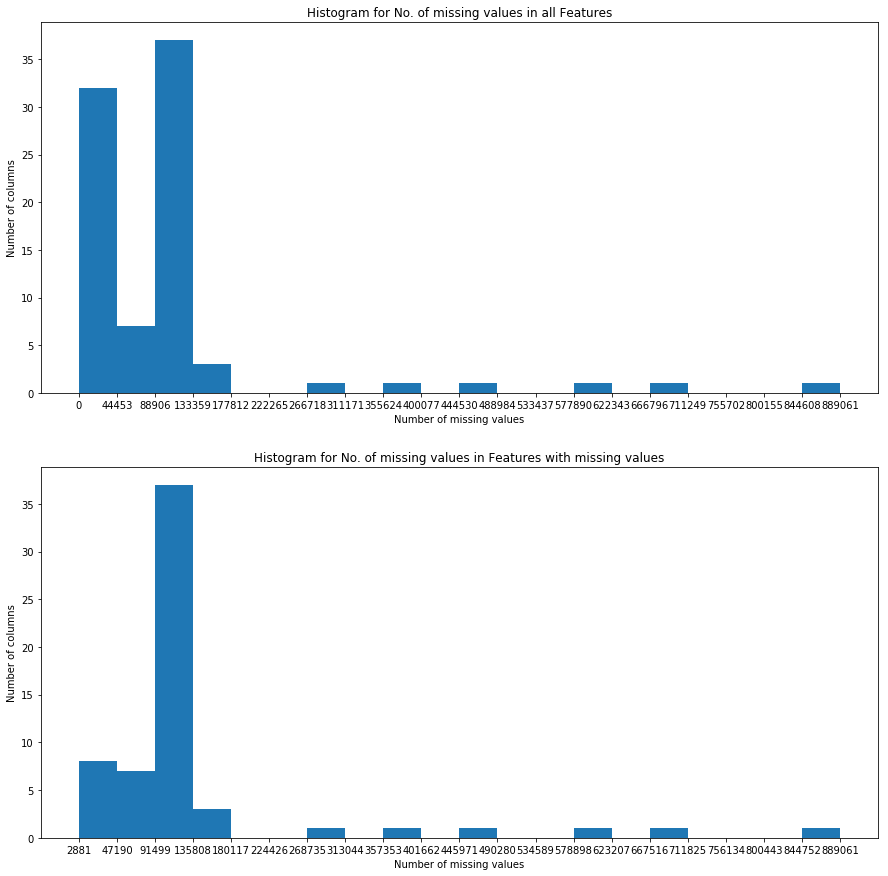

In [14]:
# Assessing how much missing data there is in each column of the dataset.
nan_azdias = azdias.isnull().sum()[azdias.isnull().sum() > 0]
# Plotting two histograms
fig,ax = plt.subplots(2,1,figsize =(15,15))
# 1st
y_,x_,_ = ax[0].hist(azdias.isnull().sum(),bins =20)
ax[0].set_title('Histogram for No. of missing values in all Features')
ax[0].set_ylabel('Number of columns')
ax[0].set_xlabel('Number of missing values')
ax[0].set_xticks(x_)
# 2nd
y_,x_,_ = ax[1].hist(nan_azdias,bins =20)
ax[1].set_title('Histogram for No. of missing values in Features with missing values')
ax[1].set_ylabel('Number of columns')
ax[1].set_xlabel('Number of missing values')
ax[1].set_xticks(x_)

In [15]:
# Investigate patterns in the amount of missing data in each column.

threshold = 130000
print('We must remove the following columns as they have more than {:.2f}% of the data missing :'.format(92000*100/len(azdias)))
cols_to_remove = nan_azdias[nan_azdias > 130000]
print(cols_to_remove.index)
print('The number of columns we are dropping is : {}'.format(len(cols_to_remove)))

We must remove the following columns as they have more than 10.32% of the data missing :
Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'W_KEIT_KIND_HH', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3',
       'KBA05_ANTG4', 'KBA05_BAUMAX', 'KBA05_GBZ', 'KKK', 'MOBI_REGIO',
       'REGIOTYP'],
      dtype='object')
The number of columns we are dropping is : 15


In [16]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
dropped_cols.extend(cols_to_remove.index)
azdias.drop(cols_to_remove.index,axis= 1,inplace = True)

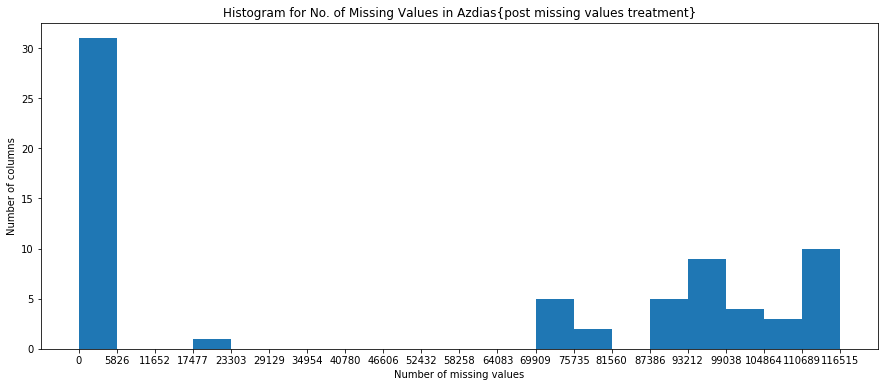

In [17]:
# Post missing value treatment histogram
fig, ax = plt.subplots(1,1,figsize = (15,6))
y_,x_,_ = ax.hist(azdias.isnull().sum(),bins =20)
ax.set_title('Histogram for No. of Missing Values in Azdias{post missing values treatment}')
ax.set_ylabel('Number of columns')
ax.set_xlabel('Number of missing values')
ax.set_xticks(x_)

#### Discussion 1.1.2: Assess Missing Data in Each Column

There were many columns containing null values. We plotted a histogram and saw that there were roughly 6 strong outliers which had more than 260,000(30%) missing values. After choosing the threshold value to be 130,000 missing values we dropped 15 columns. These were the columns with more than 14.5% of their data missing. These were chosen as the outliers as for these columns the proportion of missing data to the data present is quite big and thus this data might not help us when designing the model.

Also, in total 37 columns had around 91,500 to 1,35,800 values missing.

The columns which were removed have been mentioned above.

After seeing the post missing values treatment histogram we see that the distribution has changed a lot. The maximum number of missing values is now around 116,515.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

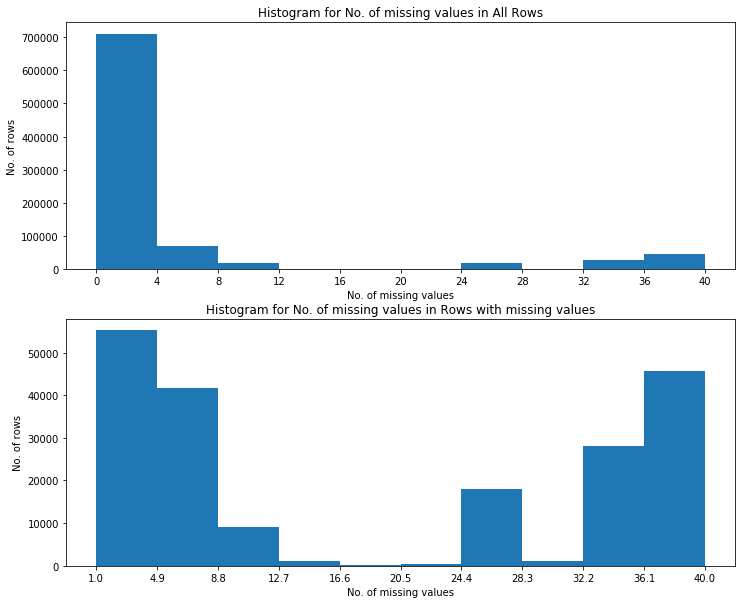

In [18]:
# How much data is missing in each row of the dataset?
# Find the rows having missing values
nan_azdias = azdias.isnull().sum(axis = 1)[azdias.isnull().sum(axis = 1) > 0]
# Plot two histograms
fig,ax = plt.subplots(2,1,figsize = (12,10))
# 1st
y_,x_,_ = ax[0].hist(azdias.isnull().sum(axis = 1))
ax[0].set_title('Histogram for No. of missing values in All Rows')
ax[0].set_xlabel('No. of missing values')
ax[0].set_ylabel('No. of rows')
ax[0].set_xticks(x_)
# 2nd
y_,x_,_ = ax[1].hist(nan_azdias)
ax[1].set_title('Histogram for No. of missing values in Rows with missing values')
ax[1].set_xlabel('No. of missing values')
ax[1].set_ylabel('No. of rows')
ax[1].set_xticks(x_)

In [19]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
# We set the threshold for missing values to be 16.6
threshold = 16.6
nan_azdias = azdias.isnull().sum(axis = 1)
azdias_clean = azdias.iloc[nan_azdias[nan_azdias <= threshold].index,:]
azdias_dirty = azdias.iloc[nan_azdias[nan_azdias > threshold].index,:]

azdias_clean = azdias_clean.reset_index()
azdias_clean.drop('index',axis = 1,inplace = True)

azdias_dirty = azdias_dirty.reset_index()
azdias_dirty.drop('index',axis = 1,inplace = True)

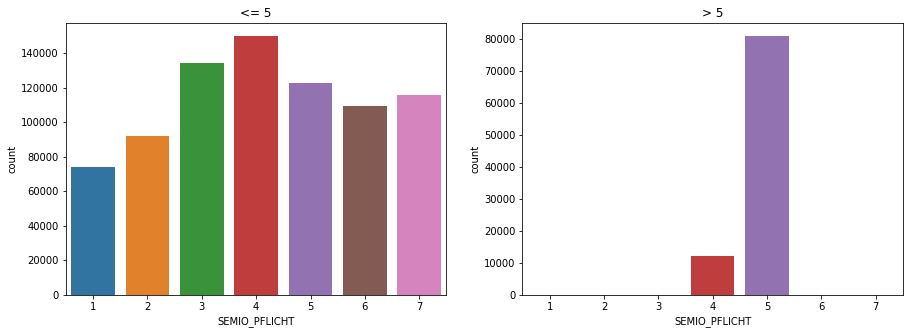

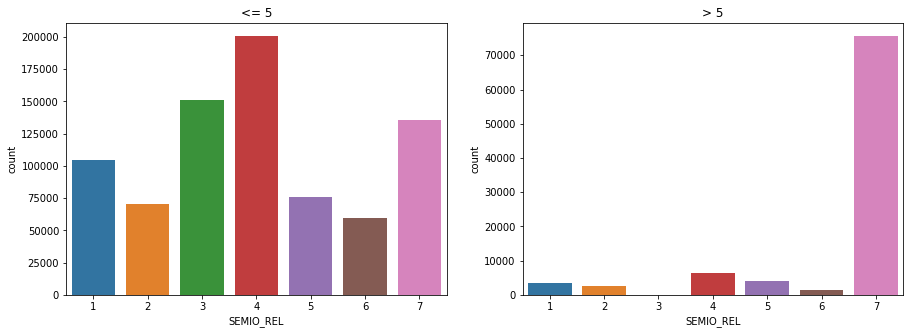

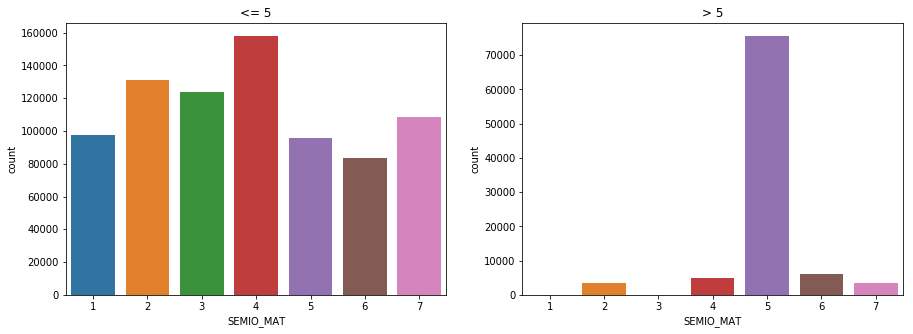

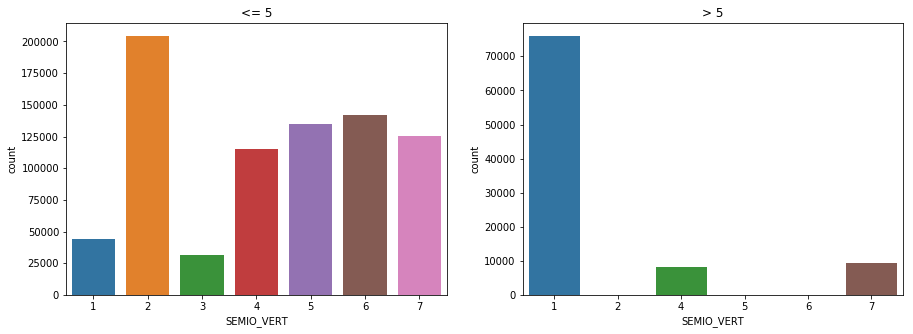

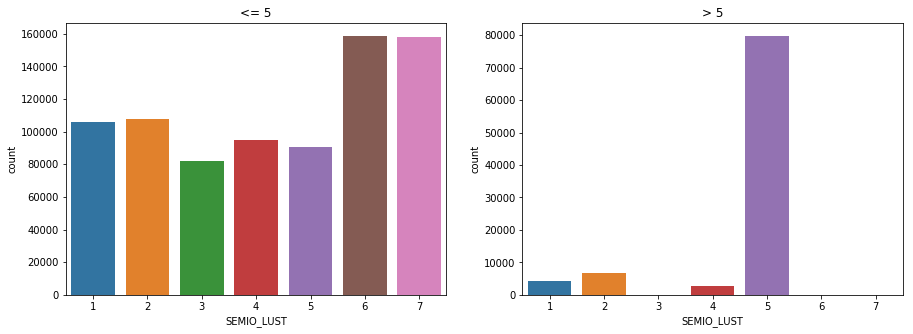

In [20]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
cols = azdias.isnull().sum(axis = 0).sort_values().head().index 
for col in cols:
    fig,ax = plt.subplots(1,2,figsize = (15,5))
    sns.countplot(x = col , data = azdias_clean.loc[:,cols],ax = ax[0])
    ax[0].set_title('<= 5')
    sns.countplot(x = col, data = azdias_dirty.loc[:,cols],ax = ax[1])
    ax[1].set_title('> 5')

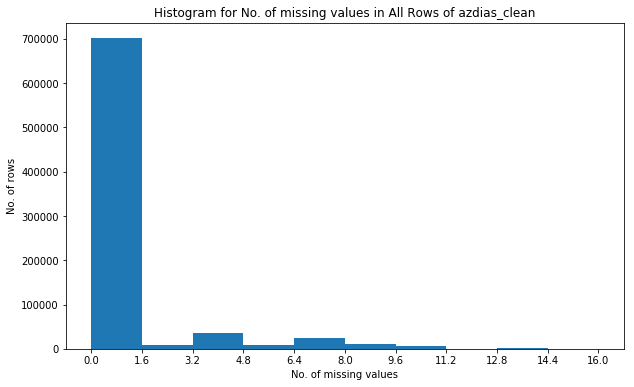

In [21]:
# Histogram for azdias_clean
fig,ax = plt.subplots(1,1,figsize = (10,6))
y_,x_,_ = ax.hist(azdias_clean.isnull().sum(axis = 1))
ax.set_title('Histogram for No. of missing values in All Rows of azdias_clean')
ax.set_xlabel('No. of missing values')
ax.set_ylabel('No. of rows')
ax.set_xticks(x_)

#### Discussion 1.1.3: Assess Missing Data in Each Row

We again saw that a lot of rows were contain missing values. But the number of rows which were containing neglible or no missing values is huge compared to the ones containing them in large numbers.

The distribution of missing values was a bimodal distribution. 16.6 was selected as the threshold as we need clean data and also we include a huge number of rows by taking 16.6 as the threshold. So we aren't really compromising on the quantity and quality of the data.The data is cut really cleanly into two parts using this value.

There were 143646 rows having more than 16.6 missing values while there were 747575 rows having 16.6 or less than 16.6 missing values.

After using countplot() from seaborn and seeing how the data was distributed in the two datasets(created above), we can see that the way values are distributed under different columns is really different for both the datasets. Thus we will mark the dataset with more than 16.6 missing values as a special case and reserve it for later use as it may tell us more about the data and its distribution.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [22]:
# How many features are there of each data type?
# Note that feat_info contains info before we deleted columns. So this isn't fully representative of the actual types.
feature_info.type.value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [23]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# We create a dictionary to store the feature name and its data types. We cycle through the 
# feature names in feature_info. We might reach an error if the feature has been removed in 
# our previous cleaning steps but we have provided for that.

info_categorical = dict()
for col_name in feature_info[feature_info.type == 'categorical'].attribute:
    try :
        values = azdias_clean[col_name].value_counts()
        types = set()
        for value in values.index:
            if type(value) == str:
                types.add('non-numeric')
            if len(values) > 2:
                types.add('multi-level') 
            else:
                types.add('binary')
        info_categorical[col_name] = types
    except:
        info_categorical[col_name] = 'not found'

print('These are the types:\n\n')
for key in info_categorical.keys():
    print(key,':',info_categorical[key])

These are the types:


AGER_TYP : not found
ANREDE_KZ : {'binary'}
CJT_GESAMTTYP : {'multi-level'}
FINANZTYP : {'multi-level'}
GFK_URLAUBERTYP : {'multi-level'}
GREEN_AVANTGARDE : {'binary'}
LP_FAMILIE_FEIN : {'multi-level'}
LP_FAMILIE_GROB : {'multi-level'}
LP_STATUS_FEIN : {'multi-level'}
LP_STATUS_GROB : {'multi-level'}
NATIONALITAET_KZ : {'multi-level'}
SHOPPER_TYP : {'multi-level'}
SOHO_KZ : {'binary'}
TITEL_KZ : not found
VERS_TYP : {'binary'}
ZABEOTYP : {'multi-level'}
KK_KUNDENTYP : not found
GEBAEUDETYP : {'multi-level'}
OST_WEST_KZ : {'non-numeric', 'binary'}
CAMEO_DEUG_2015 : {'non-numeric', 'multi-level'}
CAMEO_DEU_2015 : {'non-numeric', 'multi-level'}


W    629289
O    168507
Name: OST_WEST_KZ, dtype: int64


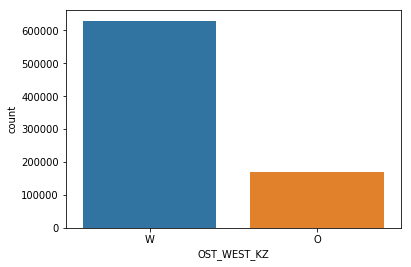

In [24]:
# Exploring the only 'binary' and 'non-numeric' feature : OST_WEST_KZ
print(azdias_clean.OST_WEST_KZ.value_counts())
sns.countplot(azdias_clean.OST_WEST_KZ)

In [25]:
# Re-encode categorical variable(s) to be kept in the analysis.

# Here we use our previous dictionary to cycle through the feature names  
# and drop the features if they are 'multi-level'.

for key in info_categorical.keys():
    if 'multi-level' in info_categorical[key]:
        azdias_clean.drop(key,axis= 1,inplace = True)
        dropped_cols.append(key)

# The only non-numeric feature is 'OST_WEST_KZ' and that can be handled directly
azdias_clean['OST_WEST_KZ'] = azdias_clean['OST_WEST_KZ'].map({'W':1,'O':0})

#### Discussion 1.2.1: Re-Encode Categorical Features

We saw that there were 21 categorical variables out of which 1 was binary and non-numeric, 2 were multi-level and non-numeric and 3 had been deleted earlier due to high number of missing values. The non-numeric binary variable OST_WEST_KZ was one-hot-encoded while all the multi-level variables were dropped to keep things simple and straight-forward.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [26]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# With the help of the information in Data_Dictionary.md, two new features,
# 'PRAEGENDE_JUGENDJAHRE_movement' and 'PRAEGENDE_JUGENDJAHRE_era', have been created.

info_mixed_1 = []
info_mixed_2 = []

for j,i in enumerate(azdias_clean.loc[:,'PRAEGENDE_JUGENDJAHRE']):
    if i in [1,3,5,8,10,12,14]:
        info_mixed_1.append('Mainstream')
    else:
        info_mixed_1.append('Avantgarde')
    if i in [1,2]:
        info_mixed_2.append('40s')
    elif i in [3,4]:
        info_mixed_2.append('50s')
    elif i in [5,6,7]:
        info_mixed_2.append('60s')
    elif i in [8,9]:
        info_mixed_2.append('70s')
    elif i in [14,15]:
        info_mixed_2.append('90s')
    else:
        info_mixed_2.append('90s')

azdias_clean = pd.concat([azdias_clean,pd.DataFrame(np.array([info_mixed_1,info_mixed_2]).T,columns = np.array(['PRAEGENDE_JUGENDJAHRE_movement','PRAEGENDE_JUGENDJAHRE_era']))],axis = 1)

In [27]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

temp_df = azdias_clean.loc[:,'CAMEO_INTL_2015'].str.split('(\d)',expand = True).iloc[:,[1,3]]
temp_df.columns = ['CAMEO_INTL_2015_1','CAMEO_INTL_2015_2']
azdias_clean = pd.concat([azdias_clean,temp_df],axis = 1)

In [28]:
# Checking which all cells have 'mixed' type.
feature_info.attribute[feature_info.type == 'mixed']

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
64             KBA05_BAUMAX
79              PLZ8_BAUMAX
Name: attribute, dtype: object

In [29]:
# Now we will be dropping 4 feature columns
to_drop = ['PLZ8_BAUMAX','WOHNLAGE','LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB']
azdias_clean.drop(to_drop, axis = 1, inplace = True)
dropped_cols.extend(to_drop)

#### Discussion 1.2.2: Engineer Mixed-Type Features

We have 7 mixed variables with us. These have values which aren't ordinal and in most cases are representing multiple pieces of information. This is what we did with the variables:

'KBA05_BAUMAX' was dropped earlier in the cleaning process

'PLZ8_BAUMAX','LP_LEBENSPHASE_GROB','WOHNLAGE' and 'LP_LEBENSPHASE_FEIN' have been dropped as I dont want the data to be too high-dimensional and one-hot-encoding these will make our dataset quite high-dimensional.

The values in 'CAMEO_INTL_2015' were split into two parts to denote different pieces on information.

Finally, 'PRAEGENDE_JUGENDJAHRE' was split into two different variables.
Both 'CAMEO_INTL_2015' and 'PRAEGENDE_JUGENDJAHRE' will be one-hot-encoded in a later section.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [30]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

In [31]:
# Taking a look at azdias_clean
azdias_clean.head(2)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_movement,PRAEGENDE_JUGENDJAHRE_era,CAMEO_INTL_2015_1,CAMEO_INTL_2015_2
0,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,Mainstream,90s,5,1
1,3.0,2,1,4,1,2,3,5,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,Avantgarde,90s,2,4


In [32]:
# Dropping original features which were engineered into new features
to_drop = ['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015']
azdias_clean.drop(to_drop, axis = 1,inplace = True)

In [33]:
# We see that there are None values in the new features we engineered above. We will 
# convert them to np.NaN values
azdias_clean.CAMEO_INTL_2015_1.fillna(value = np.NaN,inplace = True)
azdias_clean.CAMEO_INTL_2015_2.fillna(value = np.NaN,inplace = True)

In [34]:
# One-hot-encoding the below features
for col in ['PRAEGENDE_JUGENDJAHRE_movement','PRAEGENDE_JUGENDJAHRE_era','CAMEO_INTL_2015_1','CAMEO_INTL_2015_2']:
    azdias_clean = pd.concat([azdias_clean, pd.get_dummies(azdias_clean[col],prefix = col)],axis = 1)

In [35]:
# Deleting some more redundant features
for col in ['PRAEGENDE_JUGENDJAHRE_movement','PRAEGENDE_JUGENDJAHRE_era','CAMEO_INTL_2015_1','CAMEO_INTL_2015_2']:
    azdias_clean.drop(col,axis = 1,inplace = True)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [36]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    for i in range(len(feature_info)):
        # Get the ith column name and values
        col_name = feature_info.iloc[i,:]['attribute']
        col_values = df[col_name]
        # Create a list of the characters that stand for the missing values of the ith column
        missing_values = feature_info['missing_or_unknown'][i]
        missing_values_list = re.findall('[[]?(\W?\w+)[,]?',missing_values)
        # Replace the missing values with NANs. If missing value is string then error will be 
        # thrown and except portion will be executed.
        for value in missing_values_list:
            try:
                value = int(value)
                df[col_name].replace(value,np.NaN,inplace = True)
            except:
                df[col_name].replace(value,np.NaN,inplace = True)

    # remove selected columns and rows, ...
    
    # To drop columns
    getattr(df,'drop')(dropped_cols,axis = 1,inplace = True)
    # To drop rows and reset indices
    threshold = 16.6
    nan_df = getattr(df,'isnull')().sum(axis = 1)
    df_clean = getattr(df,'loc')[nan_df[nan_df <= threshold].index,:]
    df_dirty = getattr(df,'loc')[nan_df[nan_df > threshold].index,:]
    
    df_clean = df_clean.reset_index()
    df_clean.drop('index',axis = 1,inplace = True)

    df_dirty = df_dirty.reset_index()
    df_dirty.drop('index',axis = 1,inplace = True)
    
    # select, re-encode, and engineer column values.
    # Engineering new features
    df_clean['OST_WEST_KZ'] = df_clean['OST_WEST_KZ'].map({'W':1,'O':0})
    
    info_mixed_1 = []
    info_mixed_2 = []

    for j,i in enumerate(df_clean.loc[:,'PRAEGENDE_JUGENDJAHRE']):
        if i in [1,3,5,8,10,12,14]:
            info_mixed_1.append('Mainstream')
        else:
            info_mixed_1.append('Avantgarde')
        if i in [1,2]:
            info_mixed_2.append('40s')
        elif i in [3,4]:
            info_mixed_2.append('50s')
        elif i in [5,6,7]:
            info_mixed_2.append('60s')
        elif i in [8,9]:
            info_mixed_2.append('70s')
        elif i in [14,15]:
            info_mixed_2.append('90s')
        else:
            info_mixed_2.append('90s')

    df_clean = pd.concat([df_clean,pd.DataFrame(np.array([info_mixed_1,info_mixed_2]).T,columns = np.array(['PRAEGENDE_JUGENDJAHRE_movement','PRAEGENDE_JUGENDJAHRE_era']))],axis = 1)
    
    temp_df = df_clean.loc[:,'CAMEO_INTL_2015'].str.split('(\d)',expand = True).iloc[:,[1,3]]
    temp_df.columns = ['CAMEO_INTL_2015_1','CAMEO_INTL_2015_2']
    df_clean = pd.concat([df_clean,temp_df],axis = 1)
    
    # Some post everything-done-above work
    
    to_drop = ['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015']
    df_clean.drop(to_drop, axis = 1,inplace = True)
    
    df_clean.CAMEO_INTL_2015_1.fillna(value = np.NaN,inplace = True)
    df_clean.CAMEO_INTL_2015_2.fillna(value = np.NaN,inplace = True)
    
    # One-hot-encoding the below features
    for col in ['PRAEGENDE_JUGENDJAHRE_movement','PRAEGENDE_JUGENDJAHRE_era','CAMEO_INTL_2015_1','CAMEO_INTL_2015_2']:
        df_clean = pd.concat([df_clean, pd.get_dummies(df_clean[col],prefix = col)],axis = 1)
    # Deleting some more redundant features
    for col in ['PRAEGENDE_JUGENDJAHRE_movement','PRAEGENDE_JUGENDJAHRE_era','CAMEO_INTL_2015_1','CAMEO_INTL_2015_2']:
        df_clean.drop(col,axis = 1,inplace = True)
        
    # Return the cleaned dataframe and the dirty df as we need it later to create 
    # the 12th cluster
    return df_clean,df_dirty
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [37]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

print('Max % missing values :',azdias_clean.isnull().sum().max()/len(azdias_clean))
print('Min % missing values :',azdias_clean.isnull().sum().min()/len(azdias_clean))
print('Total no. of rows with missing values :',len(azdias_clean.isnull().sum(axis= 1)[azdias_clean.isnull().sum(axis= 1)>0])  )

imputer = Imputer(strategy = 'most_frequent')
azdias_imputed = pd.DataFrame(imputer.fit_transform(azdias_clean))

Max % missing values : 0.0459164999574
Min % missing values : 0.0
Total no. of rows with missing values : 74150


In [38]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_imputed),columns =azdias_clean.columns )

### Discussion 2.1: Apply Feature Scaling

We have a total of 144205 rows missing values in 1 or more column. As the number of rows is too big to just discard all of them, we impute the missing values with the option of imputing with the 'most_frequent' as 'mean' and 'median' might give float values in cases where the feature is of ordinal type or categorical type.

After that we scaled the data using the StandardScaler which scales the data in each column by making their means 0 and their variance 1. Each data value becomes a standard normal variate. We scale the data so as to remove the differences between the ranges of different features.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [39]:
# Initializing and Fitting PCA to the data.
pca = PCA()
pca.fit(azdias_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [40]:
print(pca.components_)

[[ -2.35346533e-01  -2.28686098e-02  -2.31804117e-01 ...,  -4.04535102e-02
   -5.81083567e-02  -4.22004911e-02]
 [  1.53182620e-01   9.84601113e-02  -6.63896078e-02 ...,  -6.86199775e-02
   -5.44173448e-02   2.27428061e-02]
 [  7.28546575e-02  -3.64855796e-01   1.43721562e-01 ...,  -2.39662627e-02
   -1.46903218e-02   1.10597355e-02]
 ..., 
 [  4.49481270e-13  -1.11533459e-15  -2.17572053e-14 ...,  -1.11604066e-01
   -1.42078765e-01  -1.10586143e-01]
 [  1.16012394e-13  -9.92411946e-14  -4.19347507e-13 ...,   2.66221362e-01
    3.38915987e-01   2.63793199e-01]
 [ -1.57037004e-15  -2.53272129e-16  -2.53975112e-16 ...,  -6.77256147e-06
   -8.62188271e-06  -6.71079001e-06]]


Text(0.5,1,'Components and the Cumulative Sums of their Explained Variance Ratios')

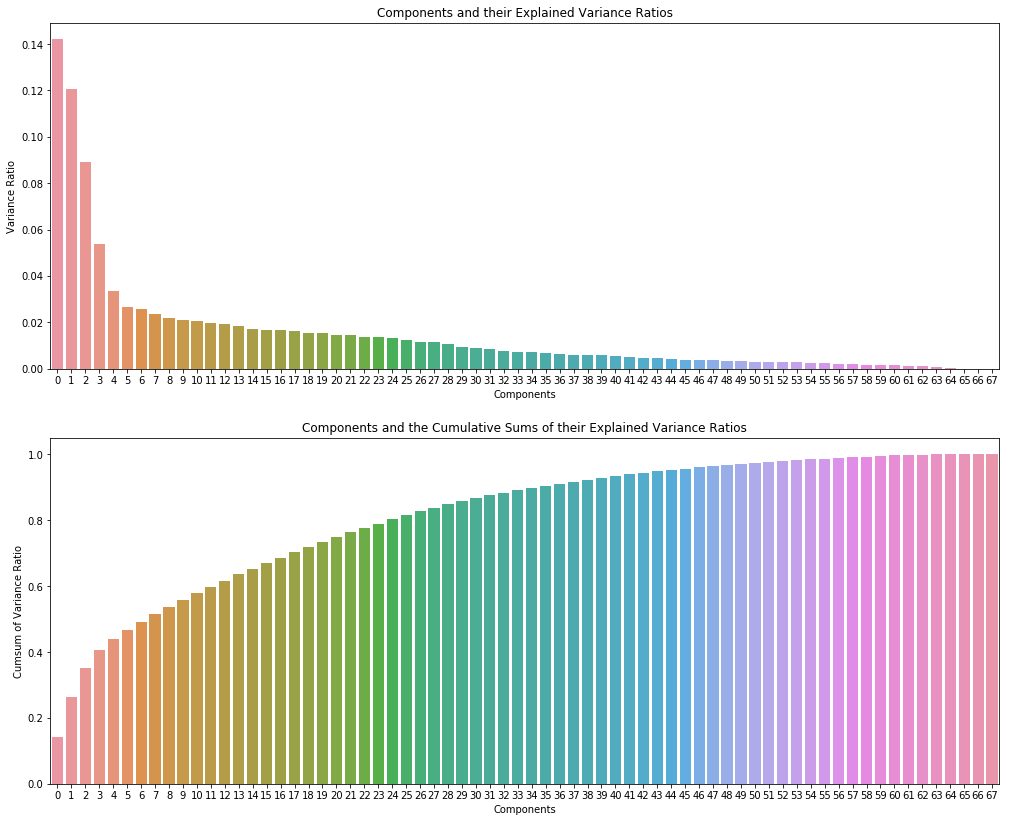

In [41]:
# Plotting the explained variance ratio and its cumulative sum
fig, ax = plt.subplots(2,1,figsize = (17,14))
var_ratio = pca.explained_variance_ratio_.round(4)
sns.barplot(x = np.arange(len(var_ratio)),y = var_ratio,ax = ax[0])
ax[0].set_title('Components and their Explained Variance Ratios')
ax[0].set_xlabel('Components')
ax[0].set_ylabel('Variance Ratio')
sns.barplot(x = np.arange(len(var_ratio)), y = np.cumsum(var_ratio),ax = ax[1])
ax[1].set_xlabel('Components')
ax[1].set_ylabel('Cumsum of Variance Ratio')
ax[1].set_title('Components and the Cumulative Sums of their Explained Variance Ratios')

In [42]:
# Investigate the variance accounted for by each principal component.
print('No. of Components:', len(np.cumsum(var_ratio)))
print('\nThe components and their respective cumsum are :')
[(i,j) for i,j in zip(range(len(var_ratio)),np.cumsum(var_ratio))]

No. of Components: 68

The components and their respective cumsum are :


[(0, 0.1421),
 (1, 0.26290000000000002),
 (2, 0.35189999999999999),
 (3, 0.40559999999999996),
 (4, 0.43889999999999996),
 (5, 0.46569999999999995),
 (6, 0.49159999999999993),
 (7, 0.5149999999999999),
 (8, 0.53699999999999992),
 (9, 0.55819999999999992),
 (10, 0.57859999999999989),
 (11, 0.59809999999999985),
 (12, 0.61729999999999985),
 (13, 0.6358999999999998),
 (14, 0.65319999999999978),
 (15, 0.67009999999999981),
 (16, 0.68689999999999984),
 (17, 0.70309999999999984),
 (18, 0.71869999999999978),
 (19, 0.73389999999999977),
 (20, 0.74859999999999982),
 (21, 0.76309999999999978),
 (22, 0.77679999999999982),
 (23, 0.79039999999999977),
 (24, 0.80359999999999976),
 (25, 0.81589999999999974),
 (26, 0.82749999999999968),
 (27, 0.83879999999999966),
 (28, 0.8494999999999997),
 (29, 0.85899999999999965),
 (30, 0.86779999999999968),
 (31, 0.87619999999999965),
 (32, 0.88389999999999969),
 (33, 0.89129999999999965),
 (34, 0.89839999999999964),
 (35, 0.90519999999999967),
 (36, 0.9114999999

In [43]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=50)
pca.fit(azdias_scaled)
# Computing the Principal Components for our data
azdias_pca = pca.transform(azdias_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

First we tried applying PCA without specifying the number of components so that all the components are computed.Thus we have 69 components. We observe that with just 30 components, over 80% of the explained variance can be shown and with 36 components over 90% can be.

Its around after the 50th component, when cumulative explained variance ratio is around 97% that the increase in explained variance ratio slows down a lot. The rest 19 components after the 50th one only explain about 3% of the explained variance. Thus, we choose to go with 50 components for our model.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [44]:
# Setting this to make sure that all rows are displayed
pd.set_option('display.max_rows', 1000)

ALTERSKATEGORIE_GROB                        -0.235347
FINANZ_MINIMALIST                           -0.231804
FINANZ_VORSORGER                            -0.220434
SEMIO_ERL                                   -0.172845
PLZ8_ANTG1                                  -0.162754
SEMIO_LUST                                  -0.152124
KONSUMNAEHE                                 -0.121791
PLZ8_GBZ                                    -0.118527
INNENSTADT                                  -0.117952
PRAEGENDE_JUGENDJAHRE_era_60s               -0.116287
RETOURTYP_BK_S                              -0.098532
PRAEGENDE_JUGENDJAHRE_era_50s               -0.092288
BALLRAUM                                    -0.089617
GREEN_AVANTGARDE                            -0.088837
CAMEO_INTL_2015_1_2                         -0.086798
GEBAEUDETYP_RASTER                          -0.086761
CAMEO_INTL_2015_1_1                         -0.084944
WOHNDAUER_2008                              -0.083395
PRAEGENDE_JUGENDJAHRE_moveme

Text(0.5,1,'First Principal Component and its Weights')

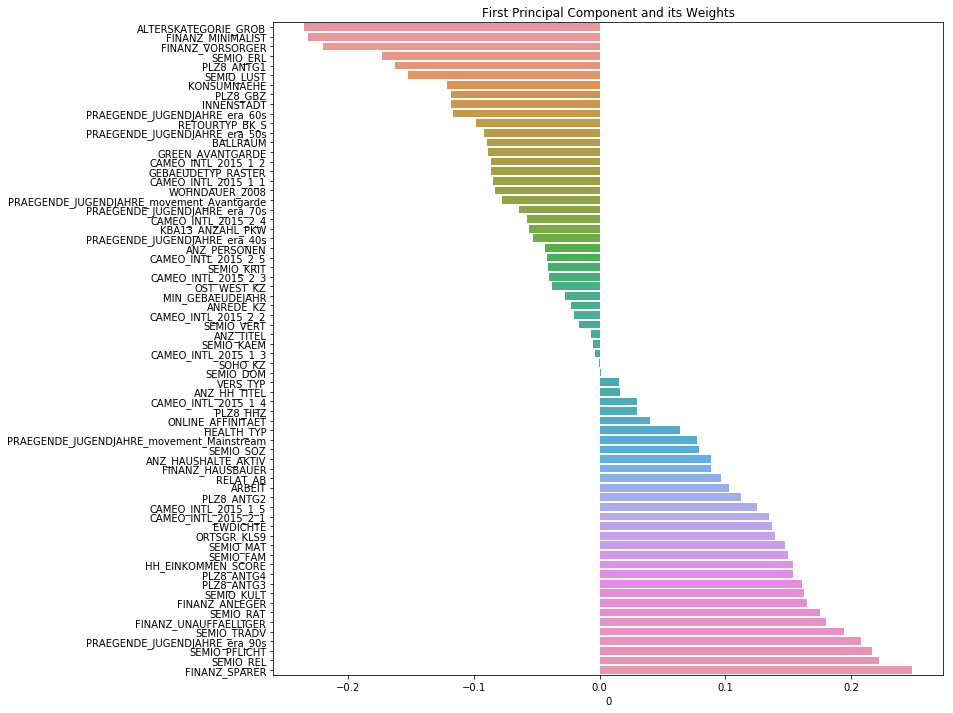

In [45]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

# The first components weights with the features have been displayed here. 
# The deductions have been noted down below in the discussion
first_pc = pd.DataFrame(pca.components_ ,columns = azdias_scaled.columns ).iloc[0,:].sort_values()
print(first_pc)
fig,ax = plt.subplots(1,1,figsize = (12,12))
sns.barplot(first_pc,first_pc.index,orient = 'horizontal')
ax.set_title('First Principal Component and its Weights')

PLZ8_ANTG1                                  -0.211755
INNENSTADT                                  -0.168498
KONSUMNAEHE                                 -0.162993
ONLINE_AFFINITAET                           -0.162615
SEMIO_REL                                   -0.161794
PLZ8_GBZ                                    -0.160884
SEMIO_KULT                                  -0.158658
FINANZ_UNAUFFAELLIGER                       -0.155724
SEMIO_TRADV                                 -0.146310
PRAEGENDE_JUGENDJAHRE_era_90s               -0.145359
FINANZ_ANLEGER                              -0.136917
BALLRAUM                                    -0.132765
SEMIO_PFLICHT                               -0.129581
SEMIO_FAM                                   -0.128064
CAMEO_INTL_2015_1_2                         -0.122499
FINANZ_SPARER                               -0.120988
GEBAEUDETYP_RASTER                          -0.107539
SEMIO_MAT                                   -0.101099
SEMIO_VERT                  

Text(0.5,1,'Second Principal Component and its Weights')

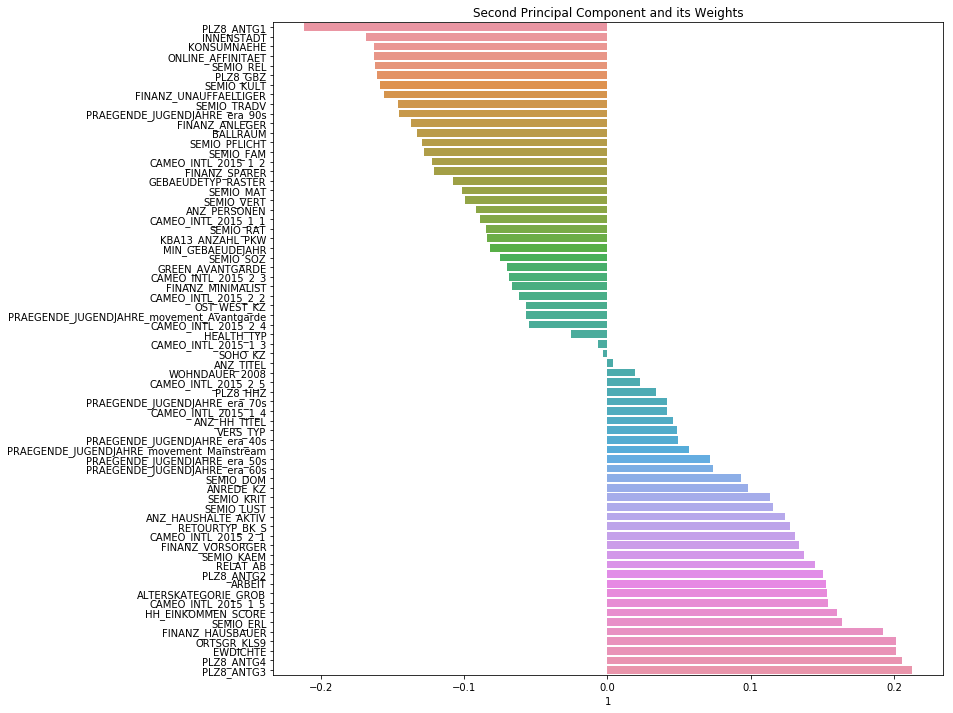

In [46]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
second_pc = pd.DataFrame(pca.components_ ,columns = azdias_scaled.columns ).iloc[1,:].sort_values()
print(second_pc)
fig,ax = plt.subplots(1,1,figsize = (12,12))
sns.barplot(second_pc,second_pc.index,orient = 'horizontal')
ax.set_title('Second Principal Component and its Weights')

ANREDE_KZ                                   -0.364856
SEMIO_KAEM                                  -0.329135
SEMIO_DOM                                   -0.307905
SEMIO_KRIT                                  -0.274650
SEMIO_RAT                                   -0.211230
FINANZ_ANLEGER                              -0.188629
SEMIO_ERL                                   -0.178283
FINANZ_SPARER                               -0.099523
FINANZ_UNAUFFAELLIGER                       -0.097457
PRAEGENDE_JUGENDJAHRE_era_90s               -0.095949
SEMIO_TRADV                                 -0.074980
SEMIO_PFLICHT                               -0.072641
PLZ8_ANTG1                                  -0.066594
INNENSTADT                                  -0.062250
KONSUMNAEHE                                 -0.054452
ONLINE_AFFINITAET                           -0.054201
PLZ8_GBZ                                    -0.053728
BALLRAUM                                    -0.050296
CAMEO_INTL_2015_1_2         

Text(0.5,1,'Third Principal Component and its Weights')

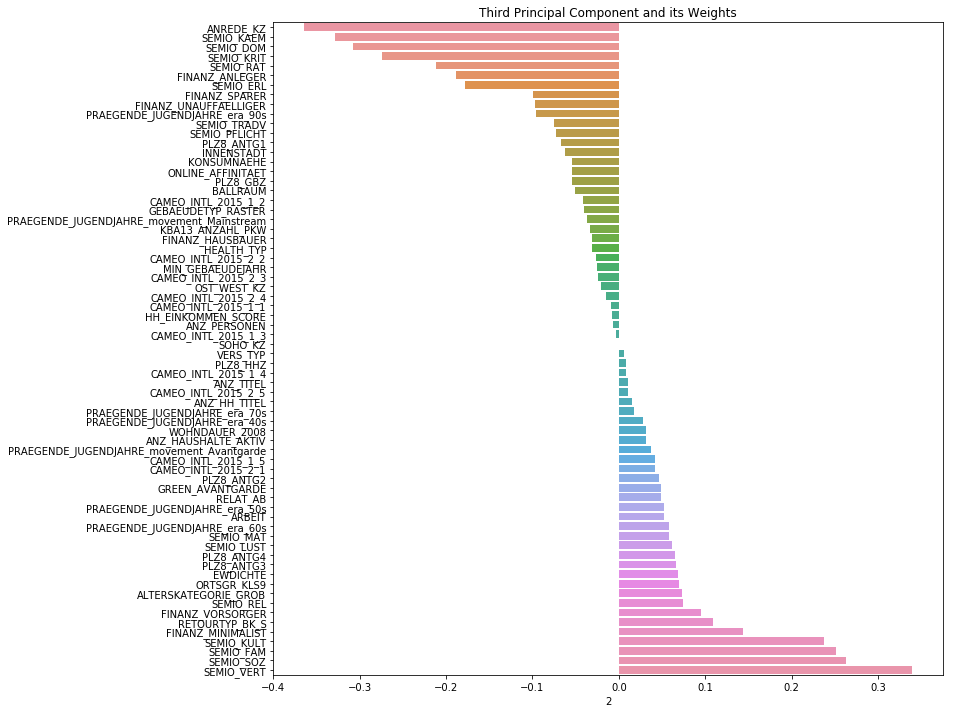

In [47]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
third_pc = pd.DataFrame(pca.components_ ,columns = azdias_scaled.columns ).iloc[2,:].sort_values()
print(third_pc)
fig,ax = plt.subplots(1,1,figsize = (12,12))
sns.barplot(third_pc,third_pc.index,orient = 'horizontal')
ax.set_title('Third Principal Component and its Weights')

### Discussion 2.3: Interpret Principal Components

1) For the first principal component we see that :

* FINANZ_SPARER and ALTERSKATEGORIE_GROB are present at opposite ends and have the maximum weights. ALTERSKATEGORIE_GROB( 1: <30 yrs and 4: >60 yrs ) gives us an estimate of the age of the person and FINANZ_SPARER tells us how much a person saves(5: Low savings  and 1: High savings). It's interesting and a little obvious to see that the older a person is the more he is likely to save and vice-versa. When people are young, they like to spend and save less while as they grow older savings increase as responsibilites fall on them and fewer things interest them. 

* We also see FINANZ_MINIMALIST(1: Max Low financial interest and 5: Min Low financial interest) with really high negative weights.So If a person is young he is more liikely to have less financial interests and vice-versa which is true again as mentioned above. 

* SEMIO_REL(Religious affinity) and SEMIO_LUST(Affinity towards Sensuality) are also located at opposite ends of the spectrum which tells us that people how are more sensual-minded are more likely very little religious minded and vice-versa.

2) For the second principal component we see that : 

* The features with the maximum weights are EWDICHTE(Denity of households per sq. km {1-6}), PLZ8_ANTG3(Number of 6-10 family houses in the PLZ8 region{0-3}) and PLZ8_ANTG1(Number of 1-2 family houses in the PLZ8 region{0-4}). PLZ8_ANTG1 and PLZ8_ANTG3 are located at opposite ends and that shows that the regions with high shares of 1-2 family houses will have low shares of 6-10 family houses and vice-versa. This tells us a lot about how regions develop. It could be that the places with a high share of 1-2 family houses are more developed and more metropolitan or closer to the centre of the city/the downtown as compared to the ones where there is a high share of 6-10 family households.

* Also EWDICHTE and PLZ8_ANTG1 are at opposite ends and that does make sense as regions with high shares of 1-2 family households are likely to have a heavy household concentration with the regions probably being where rents are expensive as it probably is closer to the downtown. Thus there are more nuclear families in these regions with heavy household density probably because of there being a lot more appartments than individual houses. To support this deduction we see that PLZ8_GBZ(Number of buildings within the PLZ8 region) has a large negative weight and thus places with high density of 1-2 family households have a large no. of buildings.

* SEMIO_FAM(How family-minded one is { 7-1 }) also has a large negative weight and supports are above deductions that the more nuclear a household is the less likely it is going to be family-minded. While families with 6-10 members are more likely to be family minded and that is shown by the negative correlation between SEMIO_FAM and PLZ8_ANTG3.

3) For the 3rd principal component we see that : 

* We see that SEMIO_VERT(Affinity towards being dreamful) and SEMIO_SOZ(affinity towards Socially-mindededness) have high positive weights indicating that people who are likely to be dreamful are likely to be more social-minded and vice-versa.

* ANREDE_KZ(Gender { 1: Male and 2: Female}) has the maximum negative weight which indicates that men are more likely to have less affinity towards being dreamful and women tend to be more dreamful. This deduction cannot be really trusted as we have a categorical variable that we are comparing with an ordinal one.

* SEMIO_DOM(Dominant-minded) and SEMIO_KAEM(Combative-minded) have opposite weights when compared to SEMIO_VERT and SEMIO_SOZ. This might tell us about how people with certain personalities don't have an affinity towards others. People who are likely to be dominant or Combative are less social-minded and less dreamful in general.  


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [48]:
# Over a number of different cluster counts...
scores = []
centroid_k = []
for k in range(2,15,1): 
    # run k-means clustering on the data and...
    cluster = MiniBatchKMeans(k)
    cluster.fit(azdias_pca)
    # compute the average within-cluster distances.
    scores.append(-cluster.score(azdias_pca))
    centroid_k.append(k)   

Text(0,0.5,'SSE')

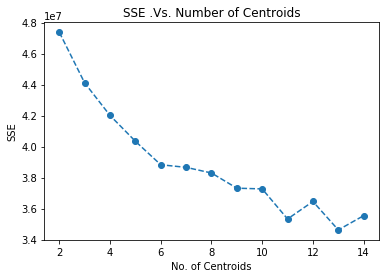

In [49]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(centroid_k, scores,linestyle = '--', marker = 'o')
plt.title('SSE .Vs. Number of Centroids')
plt.xlabel('No. of Centroids')
plt.ylabel('SSE')

In [50]:
from sklearn.cluster import KMeans

In [51]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
cluster = KMeans(12,random_state = 0)
cluster.fit(azdias_pca)

azdias_clusters = cluster.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

To understand how many clusters we want the population to be divided into, we made a scree plot for 2 to 14 cetroids. We see that the SSE (Sum of square of errors) keeps decreasing as we increase the number of centroids. Using the elbow method we observe that the changes in SSE for all k > 12 are very less. Thus having more than 12 clusters doesn't make too much of sense and doesn't really divide the data into more meaningful clusters. Hence we decide to go with 12 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [52]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',delimiter = ';')

In [53]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Clean the data with our function
customers_clean,customers_dirty = clean_data(customers)
# Impute and Scale the data
customers_imputed = pd.DataFrame(imputer.transform(customers_clean))
customers_scaled = pd.DataFrame(scaler.transform(customers_imputed),columns =customers_clean.columns )
# Fit PCA and compute principal components
pca = PCA(n_components=50)
pca.fit(customers_scaled)
customers_pca = pca.transform(customers_scaled)
# Make Clusters for customers_pca using cluster
customers_clusters = cluster.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [54]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# Proportional Value counts for clusters of customers
customers_clusters = pd.Series(customers_clusters)
all_customers_clusters = pd.concat([customers_clusters,pd.Series(np.ones(customers_dirty.shape[0])* 12)],axis = 0)
print('Clusters for customers\n')
print(all_customers_clusters.value_counts()/len(all_customers_clusters),'\n')
# Proportional Value counts for General population data
azdias_clusters = pd.Series(azdias_clusters)
all_azdias_clusters = pd.concat([azdias_clusters,pd.Series(np.ones(azdias_dirty.shape[0])* 12)],axis = 0)
print('Clusters for Population\n')
print(all_azdias_clusters.value_counts()/len(all_azdias_clusters))

Clusters for customers

12.0    0.260509
6.0     0.118042
5.0     0.097228
7.0     0.080876
10.0    0.080787
1.0     0.072428
4.0     0.065029
0.0     0.063631
11.0    0.063287
8.0     0.034923
9.0     0.032549
3.0     0.028818
2.0     0.001894
dtype: float64 

Clusters for Population

5.0     0.106352
12.0    0.104828
9.0     0.101069
6.0     0.090580
4.0     0.076617
2.0     0.076519
0.0     0.074399
11.0    0.071622
1.0     0.068743
8.0     0.065434
7.0     0.064047
3.0     0.056798
10.0    0.042992
dtype: float64


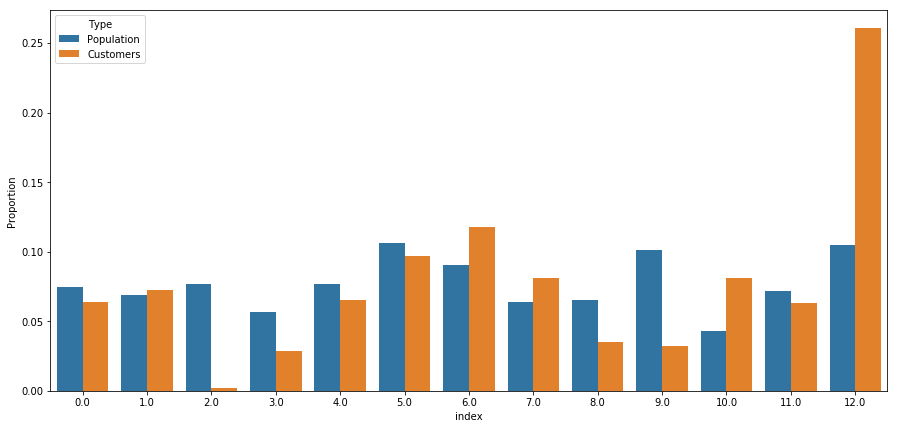

In [55]:
# Plotting both proportions wrt to their clusters
combined_clusters = pd.DataFrame([all_azdias_clusters.value_counts()/len(all_azdias_clusters),all_customers_clusters.value_counts()/len(all_customers_clusters)],index= ['Population','Customers']).T             
combined_clusters_melt = pd.melt(combined_clusters.reset_index(),id_vars = 'index',var_name = 'Type' ,value_name = 'Proportion' )

fig,ax = plt.subplots(1,1,figsize = (15,7))
sns.factorplot('index','Proportion',hue = 'Type',data = combined_clusters_melt,kind = 'bar',ax = ax)
plt.close()

In [58]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Here we will look at the 10th cluster

# First we reconstruct our original data
cluster10_azdias = scaler.inverse_transform(pca.inverse_transform(customers_pca[customers_clusters[customers_clusters == 10].index]))
cluster10_azdias = pd.DataFrame(cluster10_azdias,columns = azdias_scaled.columns)
# Now we look at the means of all the features
cluster10_azdias.mean()
#Observations have been noted below in the discussion box

ALTERSKATEGORIE_GROB                            3.405790
ANREDE_KZ                                       1.019677
FINANZ_MINIMALIST                               4.077705
FINANZ_SPARER                                   1.501448
FINANZ_VORSORGER                                4.529971
FINANZ_ANLEGER                                  1.559235
FINANZ_UNAUFFAELLIGER                           1.822793
FINANZ_HAUSBAUER                                2.967628
GREEN_AVANTGARDE                                0.000559
HEALTH_TYP                                      2.148283
RETOURTYP_BK_S                                  4.060558
SEMIO_SOZ                                       4.854213
SEMIO_FAM                                       5.000988
SEMIO_REL                                       3.844432
SEMIO_MAT                                       4.000629
SEMIO_VERT                                      6.107407
SEMIO_LUST                                      5.233796
SEMIO_ERL                      

In [59]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Here we will look at the 9th cluster

# First we reconstruct our original data
cluster9_azdias = scaler.inverse_transform(pca.inverse_transform(customers_pca[customers_clusters[customers_clusters == 9].index]))
cluster9_azdias = pd.DataFrame(cluster9_azdias,columns = azdias_scaled.columns)
# Now we look at the means of all the features
cluster9_azdias.mean()
# Observations have been noted below in the discussion box

ALTERSKATEGORIE_GROB                            3.499783
ANREDE_KZ                                       1.671458
FINANZ_MINIMALIST                               4.296433
FINANZ_SPARER                                   1.261410
FINANZ_VORSORGER                                4.699962
FINANZ_ANLEGER                                  1.393777
FINANZ_UNAUFFAELLIGER                           1.840613
FINANZ_HAUSBAUER                                2.856991
GREEN_AVANTGARDE                                0.935960
HEALTH_TYP                                      1.935098
RETOURTYP_BK_S                                  3.958865
SEMIO_SOZ                                       3.911423
SEMIO_FAM                                       3.000416
SEMIO_REL                                       2.412885
SEMIO_MAT                                       3.163342
SEMIO_VERT                                      4.135220
SEMIO_LUST                                      5.768915
SEMIO_ERL                      

### Discussion 3.3: Compare Customer Data to Demographics Data

By observing the graphs and the value count tables we can easily see that there are differences between some proportions while some of them look like they are similar.

If we first talk just about cluster 0-11: 

* The most difference in proportions is definitely for the 10th cluster where the customer proportions are overrepresented. The 1st, 6th and 7th clusters also have overrepresentation of customers as compared to the population. Thus these 4 clusters are where our marketing should be directed.

* All the other clusters have medium-high underrepresentation of customers. These should be avoided to start with and then maybe looked into if more diverese audience is needed. 2nd and 9th have really high underrepresentations.

Seeing the 12th cluster the customer proportion is huge as compared to the population proportion. Thus, we must look into this cluster later as it most probably holds some important demographic group.

Now we observed the 10th cluster to see what sort of demographics are contributing to the overrepresentation of customers vs the population :

* ALTERSKATEGORIE_GROB tells us that the age of the people in this cluster is around 45-60 . Thus we have a lot of middle-aged to old people in this cluster.
* ANREDE_KZ tells us that there are a majority of male in this cluster.
* FINANZ_MINIMALIST tells us that the people in this cluster have high financial interests.
* GREEN_AVANTGARDE : maximum people are not members of Green Avantgarde.
* SEMIO : People in this cluster have also low affinity towards being social, family-minded and dreamful and average affinity towards materialism and religion.
* OST_WEST_KZ: The majority is living in the West.
* HH_EINKOMMEN_SCORE :  People have average income in this cluster.
* WOHNDAUER_2008 : Avg. length of residence is 9-10 years
* ARBEIT : There is an low-average level of unemployment where these people are living
* ONLINE_AFFINITAET : They have high online affinity
* BALLRAUM : Average distance to an Urban Centre is about 40-50km for the people in this cluster.

Finally, we observe the 5th cluster to see the type of people we do not want to market to:

* ALTERSKATEGORIE_GROB  : 45-60 year year olds are in majority here
* ANREDE_KZ : Females are in high majority
* FINANZ_SPARER : Extremely strong money savers
* FINANZ_ANLEGER : Very Strong investors
* GREEN_AVANTGARDE : Majority are members of Green Avantgarde
* SEMIO : Social-minded, family-minded, really religious and averagely dominating type of people dominate this cluster
* OST_WEST_KZ : Most of the people live in the west



> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.